# Estimating and maximizing information with respect to multiple targets in Deep Representations

In this notebook, we showcase how `torch_mist` can be used for training neural representations, and quantitative/qualitative evaluation purposes.
This example focuses on measuring an optimizing how much information a deep `resnet18` representation contains about the position of eyes, nose and mouth in the CelebA pictures.

By estimating mutual information with a simple generative estimator, we demonstrate that a `resnet18` architecture pretrained on ImageNet contains more information than a randomly initialized architecture, and that is possible to increase the amount of information about the landmarks location by fine-tuning the encoder.
The `scripts/celeba_landmaks.py` script contains details on helper classes and training procedure.


## Loading the CelebA dataset

The `CelebALandmarks` dataset is an extension of the `torchvision.datasets.CelebA` dataset, modified to return a dictionary containing images and landmarks.

We first instantiate and visualize the training data:


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from scripts.examples.celeba_landmarks import CelebALandmarks, LANDMARKS, REPRESENTATIONS

# CelebA download location. 
DATA_DIR = '/data'

# Load the CelebA Dataset
dataset = CelebALandmarks(DATA_DIR)

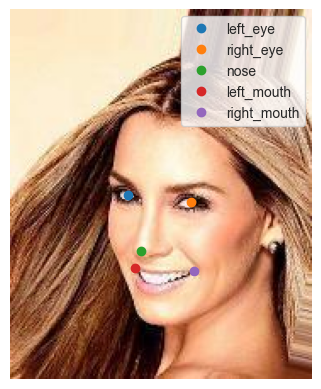

In [16]:
# Consider a datapoint
idx = 0
data = dataset[idx]

# We plot image and the corresponding landmarks
for name, value in data.items():
    if name == 'image':
        plt.imshow(value.permute(1,2,0))
    else:
        plt.plot(value[0],value[1], 'o', label=name)

plt.legend()
plt.axis('off');

In [3]:
from torch.utils.data import DataLoader, Subset

num_workers = 8

# Lastly, we define a two dataloaders for training and testing purposes 
trainloader = DataLoader(
    dataset,
    batch_size=32,
    num_workers=num_workers
)

# To speed up the evaluation process we evaluate mutual information only for the first 1000 pictures
testloader = DataLoader(
    Subset(dataset, range(1000)),
    batch_size=32,
    num_workers=num_workers
)

In [4]:
# Each batch is composed of a dictionary that contains images and all the landmarks
batch = next(iter(trainloader))
print({name: t.shape for name, t in batch.items()})

{'image': torch.Size([32, 3, 218, 178]), 'left_eye': torch.Size([32, 2]), 'right_eye': torch.Size([32, 2]), 'nose': torch.Size([32, 2]), 'left_mouth': torch.Size([32, 2]), 'right_mouth': torch.Size([32, 2])}


## Multi-Mutual Information Estimation

We use the `torch_mist` package to define 5x3 mutual information estimator (one for each landmark and for each encoder) that are jointly trained on the data using the `MultiMIEstimator` class. Each single estimator consists of an instance of `DoE` estimator. The aim of this tutorial is to show how to combine elements from `torch_mist` to easily create complex models.

### Defining the Encoders

In [5]:
import torch
from torch_mist.utils import freeze

from scripts.examples.celeba_landmarks import ResNet18Encoder


# We first define three encoders that will be used to create 3 pictures representations
encoders = {
    #   random_init: A frozen randomly initialized resnet18 encoder
    'random_init': freeze(ResNet18Encoder(weights=None)),
    #   pretrained: A frozen pre-trained resnet18 encoder
    'pretrained': freeze(ResNet18Encoder(weights="DEFAULT")),
    #   finetuned: A pre-trained resnet18 that will be finetuned with the gradient from the mi_estimator
    'finetuned': ResNet18Encoder(weights="DEFAULT"),
}

### One estimator for each pair

In [6]:
from scripts.examples.celeba_landmarks import instantiate_estimators
from torch_mist.estimators import MultiMIEstimator

# We instantiate one mutual information estimator for each pair of representation (3) and landmark (5)
estimators = instantiate_estimators()

# They are represented as a dictionary in which the key are tuple (representation, landmark) and values are the corresponding estimator
# Each estimator is defined as a difference of entropies (DoE) estimator
for (representation, landmark), estimator in estimators.items():
    print(f"({representation}, {landmark}): {estimator.__class__.__name__}")



(random_init, left_eye): DoE
(pretrained, left_eye): DoE
(finetuned, left_eye): DoE
(random_init, right_eye): DoE
(pretrained, right_eye): DoE
(finetuned, right_eye): DoE
(random_init, nose): DoE
(pretrained, nose): DoE
(finetuned, nose): DoE
(random_init, left_mouth): DoE
(pretrained, left_mouth): DoE
(finetuned, left_mouth): DoE
(random_init, right_mouth): DoE
(pretrained, right_mouth): DoE
(finetuned, right_mouth): DoE


### Aggregating estimators
We can aggregate all the estimators together using the `MultiMIEstimator` class, which handles running multiple estimators in parallel, given that it is provided with a dictionary that contains all representations and landmarks for each batch.

Note that, depending on the specified estimator, it might be possible to obtain infomax gradient with respect to the various components (landmarks or representation).
This is relevant when we are interested in training infoMax encoders, or finetuning encoders, as in this example.

In order to determine if gradient can be backpropagated, we can access the attribute `infomax_gradient`. Here we see that we can get gradient w.r.t. the representation but not the landmarks. This is because we used the `DoE` estimator, which provides gradient w.r.t. the first argument (representation) but not the second (landmarks).

In [7]:
# Aggregate the estimators
multi_estimator = MultiMIEstimator(estimators)

# Check which components receive infoMax gradient
print(multi_estimator.infomax_gradient)

{'random_init': True, 'left_eye': False, 'pretrained': True, 'finetuned': True, 'right_eye': False, 'nose': False, 'left_mouth': False, 'right_mouth': False}


### Applying transformations

Since we are interested in estimating the mutual information between the resnet representations and not the original images, we use the `TransformedMIEstimator` class to apply the 3 encoders to each image to produce 3 representations (random_init, pretrained, finetuned).

This can be done by specifying a dictionary of tuples `(name_from, name_to) : transform` which will be applied to the batch dictionary to produce a new dictionary in which the keys (random_init, pretrained, finetuned) are added as `batch[name_to] = transform(batch[name_from])`

In [8]:
from torch_mist.estimators import TransformedMIEstimator

mi_estimator = TransformedMIEstimator(
    transforms_rename={
        ("image", representation_name): encoder
        for representation_name, encoder in encoders.items()
    },
    # Use the previously defined multi_estimator after applying the transforms.
    base_estimator=multi_estimator,
)

## Training the estimators

The estimators can be easily trained using the `train_mi_estimator` utility. 
The training process requires a few hours on a single GPU.


In this example, we load an estimator trained and logged using Weights & Biases. 
Use `pip install wandb` to install the required dependencies or use `train=True` to train the model in this notebook. 

In [14]:
from torch_mist.utils.train import train_mi_estimator

train = False

if train:
    # Training procedure
    device = 'cuda'
    log = train_mi_estimator(
        estimator=mi_estimator,
        train_loader=trainloader,
        max_epochs=20,
        verbose=True,
        device=device,
    )   
else:
    # Loading from a checkpoint
    import wandb
    import os
    
    # Download the artifact corresponding to the model from wandb
    api = wandb.Api()
    artifact = api.artifact("mfederici/torch_mist/celeba_landmarks:latest")
    datadir = artifact.download()
    
    # Load the trained mutual information estimator
    trained_mi_estimator = torch.load(
        os.path.join(datadir, 'trained.pyt'), 
        map_location=torch.device('cpu')
    )
    # Copy the state dictionary (trained_mi_estimator and mi_estimator are the same)
    mi_estimator.load_state_dict(trained_mi_estimator.state_dict())
    
mi_estimator.eval();

wandb: Downloading large artifact celeba_landmarks:latest, 157.12MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


## Results and visualizations
Using the trained estimators, we can estimate the mutual information between all pairs of representations and landmarks. 

In [17]:
from torch_mist.utils import evaluate_mi

# Evaluate mutual information on a small subset (may require a few minutes on cpu)
mutual_information = evaluate_mi(
    trained_mi_estimator,
    dataloader=testloader
)

print(mutual_information)


{'I(random_init;left_eye)': 0.4707388657843694, 'I(pretrained;left_eye)': 0.9212275436148047, 'I(finetuned;left_eye)': 3.101716049015522, 'I(random_init;right_eye)': 0.47409993142355233, 'I(pretrained;right_eye)': 0.8931427914649248, 'I(finetuned;right_eye)': 2.9844541996717453, 'I(random_init;nose)': 0.6677500554360449, 'I(pretrained;nose)': 1.305055620148778, 'I(finetuned;nose)': 4.382897958159447, 'I(random_init;left_mouth)': 0.4304179784376174, 'I(pretrained;left_mouth)': 0.929740909487009, 'I(finetuned;left_mouth)': 3.1322446390986443, 'I(random_init;right_mouth)': 0.40875477041117847, 'I(pretrained;right_mouth)': 0.9572644671425223, 'I(finetuned;right_mouth)': 3.185377709567547}


And plot the values on a histogramm.

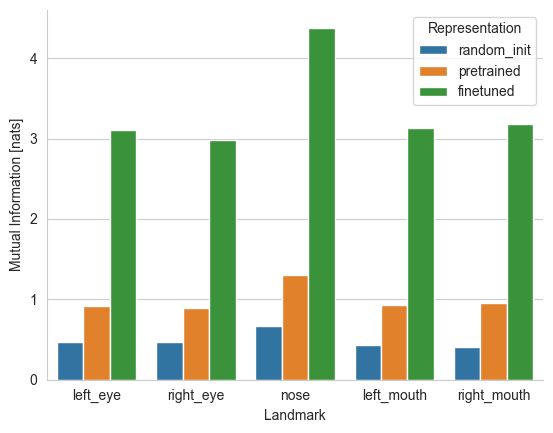

In [25]:
import pandas as pd

results = []

# For simplicity, we convert the list of the mutual information into a pandas dataframe
for name, value in mutual_information.items():
    name = name.replace('I(', '').replace(')','')
    result = {
        'Representation': name.split(';')[0],
        'Landmark': name.split(';')[1],
        'Mutual Information [nats]': value
    }
    results.append(result)

results = pd.DataFrame(results)


sns.barplot(
    results, 
    x='Landmark', hue='Representation', y='Mutual Information [nats]', 
    hue_order=REPRESENTATIONS,
    order=LANDMARKS
)
sns.despine()

Since the `DoE` estimator explicitly defines variational models $q(\text{landmark})$ and $q(\text{landmark}|\text{representation})$, we can visualize the marginal landmark distribution and the location conditioned on the various resnet representation.

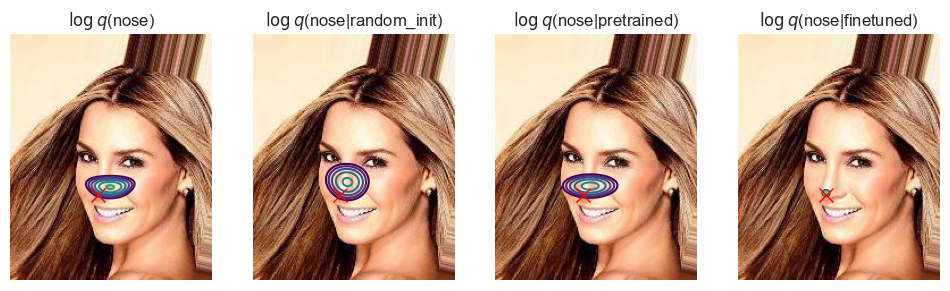

In [23]:
import numpy as np

data = {key: value.unsqueeze(0) for key, value in dataset[idx].items()}

# And the nose location as the landmark
landmark_name = 'nose'
landmark_pos = data[landmark_name].data.numpy()[0]

# Encode all the representations
img = data['image']
encoded_data = mi_estimator.transform(**data)

# Prepare the axis
f, ax = plt.subplots(
    1,len(REPRESENTATIONS)+1, 
    figsize=(len(REPRESENTATIONS)*4,4)
)

# Make a uniform grid of XY coordinates
x_axis = np.arange(img.shape[2])+1
y_axis = np.arange(img.shape[3])+1
Y, X = np.meshgrid(x_axis, y_axis)
XY = torch.cat([
    torch.FloatTensor(X).unsqueeze(-1),
    torch.FloatTensor(Y).unsqueeze(-1),
],-1)

# Consider the distribution q(nose) and evaluate the probability on the whole grid
q_Y = mi_estimator.base_estimator.estimators[f'random_init;{landmark_name}'].q_Y
q_y = q_Y.log_prob(XY).data

# Plot the image
ax[0].imshow(data['image'][0].permute(1,2,0))
# and the marginal probability corresponding to the nose location
ax[0].contour(X, Y, q_y, levels=np.linspace(-10,-1, 10), cmap='viridis')
# together with the actual nose location
ax[0].plot(landmark_pos[0], landmark_pos[1], 'xr', markersize=10)
ax[0].set_title(f'$\\log q$({landmark_name})')
ax[0].axis('off')

# Plot the same for each of the q(nose|representation) (one for each representation)
for i, representation_name in enumerate(REPRESENTATIONS):
    
    representation = encoded_data[representation_name].unsqueeze(0)
    # Consider q(nose|representation) and compute the probability on the whole grid
    q_Y_given_X = mi_estimator.base_estimator.estimators[f'{representation_name};{landmark_name}'].q_Y_given_X
    q_y_given_x = q_Y_given_X.condition(representation).log_prob(XY).data
    
    # Plot the image and the corresponding probability contour and ground truth location
    ax[i+1].imshow(data['image'][0].permute(1,2,0))
    ax[i+1].contour(X, Y, q_y_given_x, levels=np.linspace(-10,0, 10), cmap='viridis')
    ax[i+1].set_title(f'$\\log q$({landmark_name}|{representation_name})')
    ax[i+1].plot(landmark_pos[0], landmark_pos[1], 'xr', markersize=10)
    ax[i+1].axis('off')

Clearly the randomly initialized network contains less infomation regarding the location of the landmarks than a network pretrained on image classification.
As expected, fine-tuning the representation to maximize the landmark-position-predictive information yields the most informative representations. This can also be seen by comparing the sharpness of the posterior distribution. 

Therefore, we may infer that the pre-training procedure on ImageNet makes the network capture more information regarding the location of facial features when compared to a randomly initialized model, but most of the information regarding their position is lost in the encoding process.